## 3DCNN model evalutaion

In [1]:
import pandas as pd
import joblib as jbl
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder

### Split

In [2]:
def get_train_test_indeces(Y_path, test_subjects: int = None, shuffle: bool = True, test_size: float = None):
    labels = pd.read_csv(Y_path, index_col="Unnamed: 0")
    test_idx = None
    train_idx = None
    indeces = np.arange(len(labels))
    if shuffle:
        np.random.seed(44) 
        np.random.shuffle(indeces)
    unique_groups = None
    if "subject" in labels.columns and test_subjects:
        groups = labels["subject"].values
        unique_groups = np.unique(groups)

        test_groups = np.random.choice(unique_groups, size=test_subjects, replace=False)
        test_mask = labels["subject"].isin(test_groups)
        size = sum(test_mask) / len(test_mask)
        if test_size != None:
            while abs(test_size - size) > 0.05:
                test_groups = np.random.choice(unique_groups, size=test_subjects, replace=False)
                test_mask = labels["subject"].isin(test_groups)
                size = sum(test_mask) / len(test_mask)
        train_idx = labels.index[~test_mask]
        test_idx = labels.index[test_mask]
    else:
        test_start = int((1-test_size) * len(labels))
        train_idx = indeces[0:test_start]
        test_idx = indeces[test_start:]

    if "subject" in labels.columns:
        labels.drop("subject", axis=1, inplace=True)

    return train_idx, test_idx, labels

train_idx, test_idx, labels = get_train_test_indeces("../data/union+subject.csv", shuffle=True, test_subjects=None, test_size=0.2)
display(labels.head(5))

,AU5,AU24,AU43,AU64,AU17,AU7,AU1,AU20,AU39,AU6,...,AU15,AU12,AU16,AU63,AU10,AU45,AU26,AU9,AU25,emotion
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,happiness
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others


In [3]:
data_casme = jbl.load("../data/casme_regional_spatiotemporal_features.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_regional_spatiotemporal_features.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)

(256, 8, 224, 224)
(267, 8, 224, 224)
(523, 8, 224, 224)


In [4]:
labels["emotion"] = labels["emotion"].apply(lambda x: x.lower())
NUM_EMOTIONS = len(labels["emotion"].unique())
NUM_AUS = len(labels.columns[1:])
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]
le = LabelEncoder()
le.fit(labels["emotion"])
emotions = le.transform(labels["emotion"])
aus = labels[labels.columns[:-1]].to_numpy()
DATA_SIZE = concatted.shape[0]

We need to alter the class weights for emotions

In [5]:
emotion_counts = labels["emotion"].value_counts()
display(emotion_counts)
display(labels[labels.columns[:-1]].sum())
inverse_freq = 1 / emotion_counts.values
inverse_freq = np.ceil(20 * (inverse_freq / np.max(inverse_freq)))
codes = le.transform(emotion_counts.keys())
arg_sorted = np.argsort(codes)
class_weights = inverse_freq[arg_sorted]

emotion
others                 130
negative               127
disgust                 64
surprise                54
positive                34
repression              33
happiness               32
surprise+positive       14
surprise+negative        8
positive+repression      8
sadness                  7
negative+repression      7
surprise+repression      3
fear                     2
Name: count, dtype: int64

AU5      10
AU24     11
AU43      1
AU64      1
AU17     36
AU7     128
AU1      72
AU20      3
AU39      4
AU6      38
AU4     232
AU2      76
AU38      2
AU18      1
AU14     31
AU15     22
AU12     87
AU16      1
AU63      2
AU10     18
AU45     34
AU26      1
AU9      14
AU25      2
dtype: int64

In [6]:
training = tf.data.Dataset.from_tensor_slices((concatted[train_idx], (emotions[train_idx], aus[train_idx]))).shuffle(buffer_size=len(train_idx), seed=255).batch(1).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((concatted[test_idx], (emotions[test_idx], aus[test_idx]))).batch(1).prefetch(tf.data.AUTOTUNE)
'''
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
'''

'\ndataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)\nvalidation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\ntraining = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\n'

In [7]:
class_weights = tf.cast(tf.constant(class_weights), dtype=tf.float32)

def weighted_loss(y_true, y_pred):
    weight = tf.gather(class_weights, y_true)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return loss * weight


def basic_block(inputs, filter_num, stride=1):
    x = tf.keras.layers.Conv3D(filters=filter_num, kernel_size=(1,3,3), strides=stride, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv3D(filters=filter_num, kernel_size=(1,3,3), strides=1, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    shortcut = inputs
    if filter_num != inputs.shape[-1] or stride != 1:
        shortcut = tf.keras.layers.Conv3D(filters=filter_num, kernel_size=(1,3,3), strides=stride, padding="same")(inputs)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def make_blocks(inputs, filters, blocks, stride=(1,1,1)):
    x = basic_block(inputs, filters, stride=stride)
    for _ in range(1, blocks):
        x = basic_block(x, filters, stride=(1,1,1))
    return x

def encoder(input_shape=None, pooling="avg"):
    video_in = tf.keras.layers.Input(shape=input_shape)
    
    # initial temporal+spatial compression
    x = tf.keras.layers.Conv3D(64, (8,8,8), strides=(1,8,8), padding="valid")(video_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling3D((1,2,2), padding="valid")(x) 
    
    # residual stacks with small temporal kernel
    x = make_blocks(x, 64, blocks=1, stride=(1,2,2)) 
    x = make_blocks(x, 128, blocks=1, stride=(1,2,2)) 
    x = make_blocks(x, 256, blocks=1, stride=(1,2,2))  
    x = tf.keras.layers.Dropout(0.1)(x)
    if pooling == "avg":
        x = tf.keras.layers.GlobalAveragePooling3D()(x)
    elif pooling == "max":
        x = tf.keras.layers.GlobalMaxPooling3D()(x)
    else:
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dropout(0.3)(x)

    return tf.keras.Model(video_in, x)

def build_3d_cnn(input_shape=(8, 112, 112, 1), num_emotions=7, num_aus=12, lstm_hidden=256, dropout_f = 0.5):

    T, H, W, C = input_shape
    transform_in = tf.keras.layers.Input(shape=input_shape, name="video_in") 
    enc = encoder(input_shape=(T, H,W,C), pooling="max")
    dense = tf.keras.layers.Dense(lstm_hidden, activation="relu",)(enc(transform_in))
    dropout = tf.keras.layers.Dropout(dropout_f)(dense)
    emotion_logits = tf.keras.layers.Dense(num_emotions, name="emotion_logits", activation="softmax")(dropout)
    au_logits = tf.keras.layers.Dense(num_aus, name="au_logits", activation="sigmoid")(dropout)

    model = tf.keras.Model(inputs=transform_in, outputs=[emotion_logits, au_logits], name="3D_CNN_3DFFT_INPUT")
    return model

Model: "3D_CNN_3DFFT_INPUT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 video_in (InputLayer)          [(None, 8, 224, 224  0           []                               
                                , 1)]                                                             
                                                                                                  
 model (Functional)             (None, 256)          1624960     ['video_in[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 256)          65792       ['model[0][0]']                  
                                                                                                  
 dropout_1 (Dropout)            (None, 256)          0           ['dense[0][0]'] 

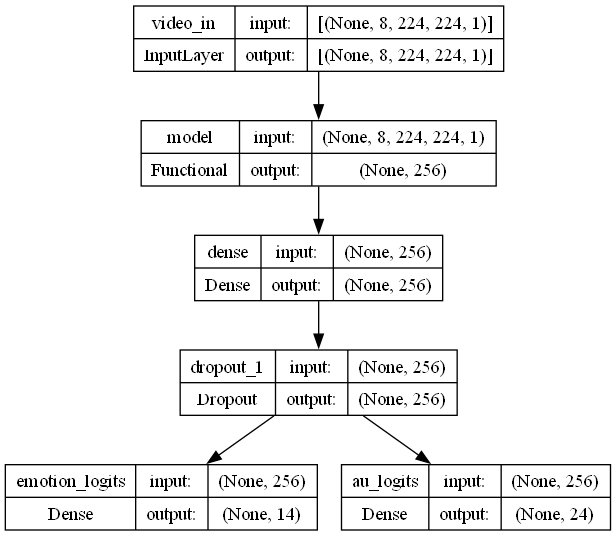

In [8]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
model.summary()
display(tf.keras.utils.plot_model(model, show_shapes=True,expand_nested=False))

In [9]:
EPOCHS = 30

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, gamma = 2) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0,
                  "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1) #

Epoch 1/30
418/418 [==============================] - 15s 24ms/step - loss: 6.5407 - emotion_logits_loss: 6.0899 - au_logits_loss: 0.2254 - emotion_logits_sparse_categorical_accuracy: 0.1292 - au_logits_auc: 0.4890 - val_loss: 4.1927 - val_emotion_logits_loss: 4.0072 - val_au_logits_loss: 0.0927 - val_emotion_logits_sparse_categorical_accuracy: 0.1810 - val_au_logits_auc: 0.3239
Epoch 2/30
418/418 [==============================] - 10s 23ms/step - loss: 5.0092 - emotion_logits_loss: 4.8371 - au_logits_loss: 0.0861 - emotion_logits_sparse_categorical_accuracy: 0.1627 - au_logits_auc: 0.5065 - val_loss: 4.2331 - val_emotion_logits_loss: 4.1406 - val_au_logits_loss: 0.0462 - val_emotion_logits_sparse_categorical_accuracy: 0.2095 - val_au_logits_auc: 0.3086
Epoch 3/30
418/418 [==============================] - 9s 23ms/step - loss: 4.6159 - emotion_logits_loss: 4.4721 - au_logits_loss: 0.0719 - emotion_logits_sparse_categorical_accuracy: 0.2368 - au_logits_auc: 0.4815 - val_loss: 3.8776 - v

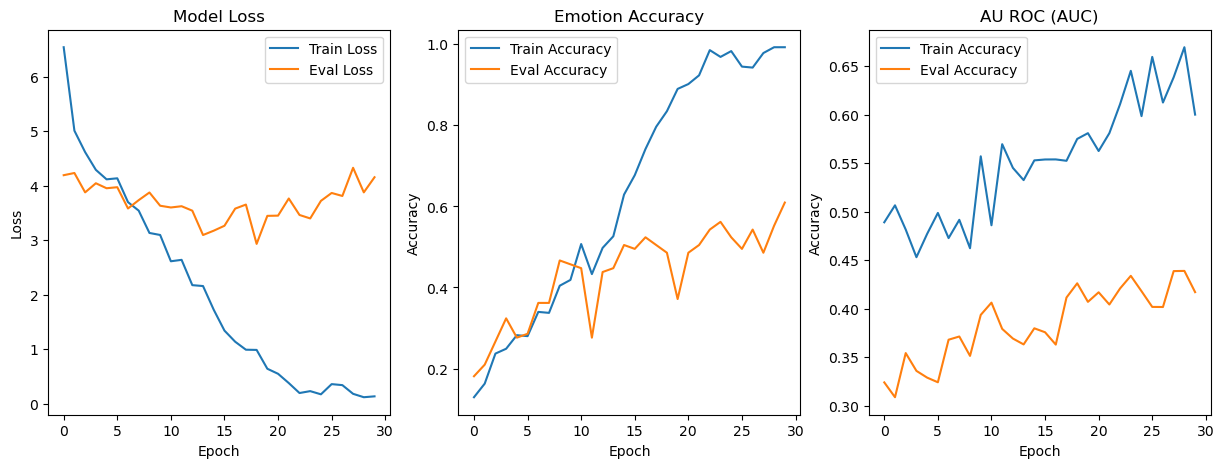

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

         AU5        nan      0.00      0.00         3
        AU24        nan      0.00      0.00         2
        AU43        nan       nan       nan         0
        AU64        nan       nan       nan         0
        AU17        nan      0.00      0.00         5
         AU7       0.00      0.00      0.00        23
         AU1        nan      0.00      0.00        16
        AU20        nan       nan       nan         0
        AU39        nan       nan       nan         0
         AU6        nan      0.00      0.00         8
         AU4       0.83      0.10      0.18        49
         AU2        nan      0.00      0.00        18
        AU38        nan       nan       nan         0
        AU18        nan      0.00      0.00         1
        AU14        nan      0.00      0.00         5
        AU15        nan      0.00      0.00         4
        AU12       0.00      0.00      0.00        18
        AU16        nan    

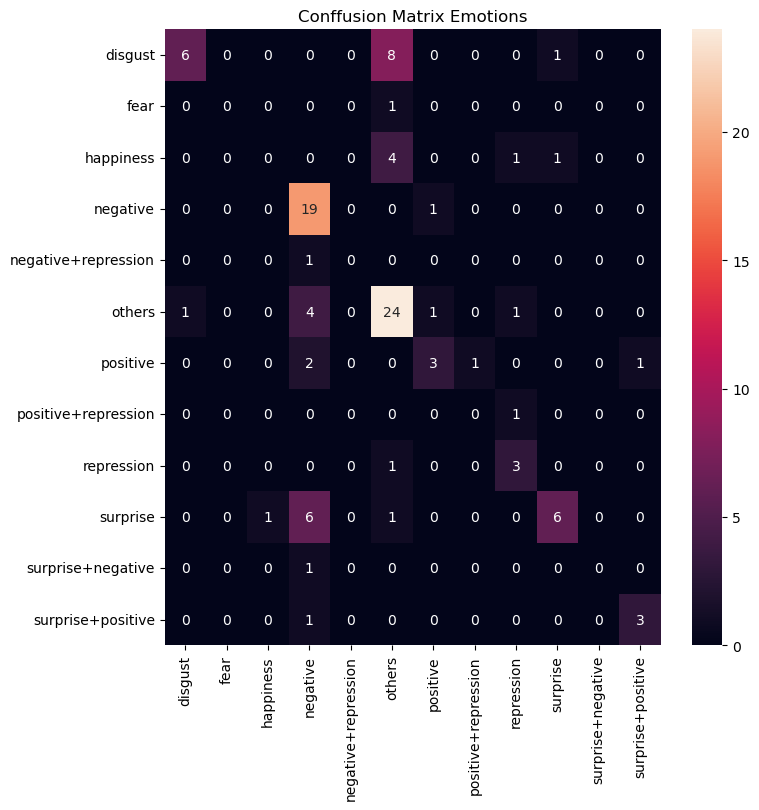

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore", message=r".*UndefinedMetricWarning.*")

def results(history, prefix = ""):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    emotion_train_accuracy = history.history['emotion_logits_sparse_categorical_accuracy']
    emotion_val_accuracy =  history.history['val_emotion_logits_sparse_categorical_accuracy']
    au_train_accuracy =  history.history['au_logits_auc'+ prefix]
    au_val_accuracy =  history.history['val_au_logits_auc'+ prefix]

    def plot_history(data_1, data_2, label, subplot, title):
        x = np.arange(EPOCHS)
        plt.subplot(1, 3, subplot)
        plt.plot(x, data_1, label = f"Train {label}")
        plt.plot(x, data_2, label = f"Eval {label}")
        plt.xlabel("Epoch")
        plt.ylabel(label)
        plt.legend()
        plt.title(title)

    plt.figure(figsize = (15, 5))
    plot_history(loss, val_loss, "Loss", 1, "Model Loss")
    plot_history(emotion_train_accuracy, emotion_val_accuracy, "Accuracy", 2, "Emotion Accuracy")
    plot_history(au_train_accuracy, au_val_accuracy, "Accuracy", 3, "AU ROC (AUC)")
    plt.show()

results(history, "")
def eval_model(validation_data, model):
    true_emotions = []
    true_AUs = []
    pred_emotions = []
    pred_AUs = []
    count = 0
    for video, (emotion, au_vector) in validation_data:
        count += 1
        true_emotions.append(emotion.numpy().squeeze())
        true_AUs.append(au_vector.numpy().squeeze())
        pred = model.predict(video, verbose = 0)
        pred_emotions.append(np.argmax(pred[0]))
        pred_AUs.append((pred[1] > 0.5).astype(np.int32).squeeze())
    cr_aus = classification_report(true_AUs, pred_AUs, target_names = labels.columns[:-1], zero_division=np.nan)
    pred_emotions = le.inverse_transform(pred_emotions)
    true_emotions = le.inverse_transform(true_emotions)
    cr_emotions = classification_report(true_emotions, pred_emotions)
    cm_emotions = confusion_matrix(true_emotions, pred_emotions)
    print(cr_aus)
    print(cr_emotions)
    plt.figure(figsize=(8,8))
    target_names_emotions =  np.unique(true_emotions)
    sns.heatmap(cm_emotions, annot=True, fmt= "d", xticklabels=target_names_emotions, yticklabels=target_names_emotions)
    plt.title("Conffusion Matrix Emotions")
    plt.show()

eval_model(validation, model)